# hypercat
### A short overview of _hypercat_ : Hypercube of CLUMPY AGN Tori

**hypercat** is the *Hypercube of CLUMPY AGN Tori* and comes with the 9-dimensional cube, and a number of convenient tools written in Python, to operate on the cube and on extracted images. The two most important objects provided by the code are `ModelCube` and `Image`.

### Download the cube, unpack, verify, get started
Make sure that you download the current [hypercube HDF5 file](https://drive.google.com/open?id=0B41msudQMpzZaXpaVzhELUNNSHc). It is ~2.6 GB big. Once you have it, check integrity and unzip:

```shell
foo/>md5sum clumpy_img_cube_2200models_19waves_halfsized_uncompressed.hdf5.gz
964f04d02642de44aa5af02318ee9d28

foo/>gunzip clumpy_img_cube_2200models_19waves_halfsized_uncompressed.hdf5.gz
```

Start Ipython via ```ipython --pylab```, then import hypercat and helper modules, define a simple plotting function:

In [1]:
import hypercat
import pylab as p
import numpy as N
import itertools
from astropy import units as u
import matplotlib
%matplotlib inline

__author__ = 'Robert Nikutta <robert.nikutta@gmail.com>'
__version__ = '20160627'  #yyyymmdd

def multiplot(images,figsize=(10,3),geometry=(1,3),colorbars=True,titles=None,interpolation='bicubic'):
    
    n = len(images)
    assert (n <= N.prod(geometry))

    if titles is not None:
        assert (len(titles) == n)
    
    nrow, ncol = geometry
    
    try:
        cmap = p.cm.viridis
    except AttributeError:
        cmap = p.cm.jet
    
    fig = p.figure(figsize=figsize)
    for j in xrange(n):
        ax = fig.add_subplot(nrow,ncol,j+1)
        im = ax.imshow(images[j].T,origin='lower',interpolation=interpolation,cmap=cmap)
        if titles is not None:
            ax.set_title(titles[j])
        if colorbars is True:
            p.colorbar(im)
            
    p.tight_layout()

##The ModelCube object##
Now make an instance of the ModelCube. This object holds the image hypercube data, and has flexible methods to extract images from it. Instantiating can take a few moments (currently ~6 seconds from a SSD), and you need to have sufficient RAM available (currently ~3.8 GB).

In [2]:
# adjust the path for 'hdffile'
M = hypercat.ModelCube(hdffile='clumpy_img_cube_2200models_19waves_halfsized_uncompressed.hdf5')

The object ```M``` has several useful methods. Check out the names and ranges of the sampled model parameters:

In [3]:
M.print_sampling(n=6)

Parameter Range                Nvalues  Values
------------------------------------------------------------------------
 sig      [ 15.000 -  60.000]  (  4)    15.000, 30.000, 45.000, 60.000
   i      [  0.000 -  90.000]  ( 11)     0.000, 25.842, 36.870, 45.573, 53.130, 60.000, ...
   N      [  1.000 -   9.000]  (  5)     1.000,  3.000,  5.000,  7.000,  9.000
   q      [  0.000 -   1.000]  (  2)     0.000,  1.000
  tv      [ 10.000 -  80.000]  (  5)    10.000, 20.000, 40.000, 60.000, 80.000
   x      [  0.000 - 110.000]  (111)     0.000,  1.000,  2.000,  3.000,  4.000,  5.000, ...
   y      [  0.000 - 220.000]  (221)     0.000,  1.000,  2.000,  3.000,  4.000,  5.000, ...
wave      [  1.200 - 870.000]  ( 19)     1.200,  2.200,  3.500,  4.800,  8.700,  9.300, ...


The parameter names are in the left column (x & y are the image pixel axes). You can adjust the number of shown elements, and the format used. See ```M.print_sampling?```

###Get an image for arbitrary model parameters###
Let's define a vector of model parameter values for which we would like to see the image. Note that ```x``` and ```y``` need not be specified (we want the whole ```x```-by-```y``` image. Specify only the free model parameters, in the order printed in the table above (and including the wavelength in microns):

In [4]:
theta = (30,60,3,0,20,10.0)  # sig,i,N,q,tv,wave

Obtaining the image is very simple:

In [5]:
image = M.get_image(theta)

Check its shape:

In [6]:
image.shape

(221, 221)

Let's plot this 10-micron brightness map with our little plotting function:

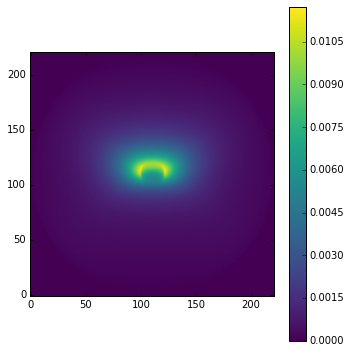

In [7]:
multiplot((image,),figsize=(5,5),geometry=(1,1))

###Interpolation accuracy###
How good is the interpolation? We can check by comparing the interpolated image to its directly sampled counterpart (we've chosen ```theta``` above such that there actually _is_ an original image in the hypercube):

max. deviation =  0.0


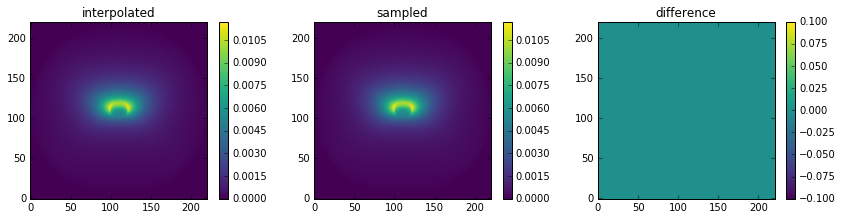

In [8]:
image_sampled = hypercat.mirror_halfimage(M.data[1,5,1,0,1,:,:,7])  # the indices correspond to the theta above
images = [image,image_sampled,(image-image_sampled)]
multiplot(images,figsize=(12,3),geometry=(1,3),titles=('interpolated','sampled','difference'))
print "max. deviation = ", N.abs(images[-1]).max()

Excellent! In this case the deviation is zero everywhere. In some other cases I've seen absolute deviations on the order of 1e-10, i.e. entirely negligible.

###Multiple wavelengths###
It's easy to obtain images at several wavelengths: you just call ```M.get_image(...)``` several times, varying the wavelength each time. But we can do it even simpler:

In [9]:
waves = (2.2,4.8,9.5,10.0,22)  # tuple of multiple wavelengths
theta = (30.,60,3,0,20,waves)  # sig,i,N,q,tv, multiple wavelengths(!)
image = M.get_image(theta)

Let's inspect the shape of this "image" array:

In [10]:
image.shape

(221, 221, 5)

Apparently this an image cube, with 5 wavelength slices. Let's plot them:

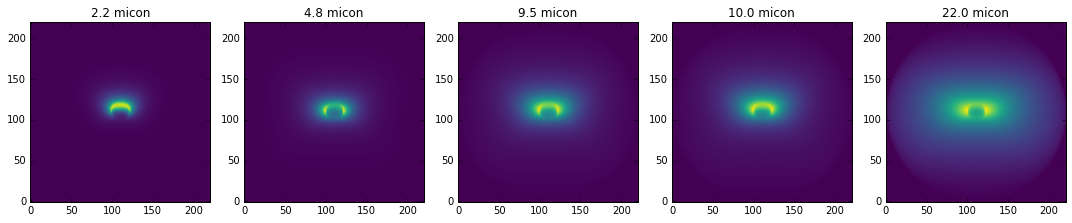

In [11]:
images = [image[...,j] for j in xrange(5)]  # extract the 2D slices
multiplot(images,figsize=(15,5.5),geometry=(1,5),colorbars=False,titles=['%.1f micon' % w for w in waves])

###Multi-_everything_###
In fact, this automatic n-dimensional image interpolation at multiple values of a parameter is even more powerful. Say we wanted to see the same image, but at varying values of ```sig``` (the torus angular widths, measured in degrees):

In [12]:
sig = (20,30,40,50,60)  # multiple values for sig
theta = (sig,60,3,0,20,10.0)  # multiple sig, i,N,q,tv,wave
image = M.get_image(theta,full=False)  # the hypercube stores half-images, but func mirror_halfimage is not yet fully generic
image.shape

(5, 111, 221)

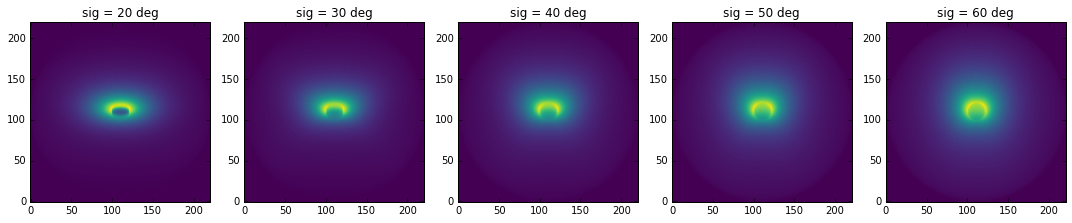

In [13]:
images = [hypercat.mirror_halfimage(image[j,...]) for j in xrange(5)]  # extract slices and make square images
multiplot(images,figsize=(15,5.5),geometry=(1,5),colorbars=False,titles=['sig = %d deg' % s for s in sig])

This multi-everything is _entirely generalized_:

In [14]:
sig = (20,30,40,50,60)  # multiple values for sig
waves = (2.2,10.0,160)  # multiple wavelengths
theta = (sig,60,3,0,20,waves)  # multiple sig, i,N,q,tv, multiple waves
image = M.get_image(theta,full=False)  # the original hypercube stores half-images
image.shape

(5, 111, 221, 3)

This "cube" is now 4-dimensional! The first index is for the 5 slices of sig, then come x and y, and the last index is for the 3 wavelength slices. Let's make square versions, and plot them all:

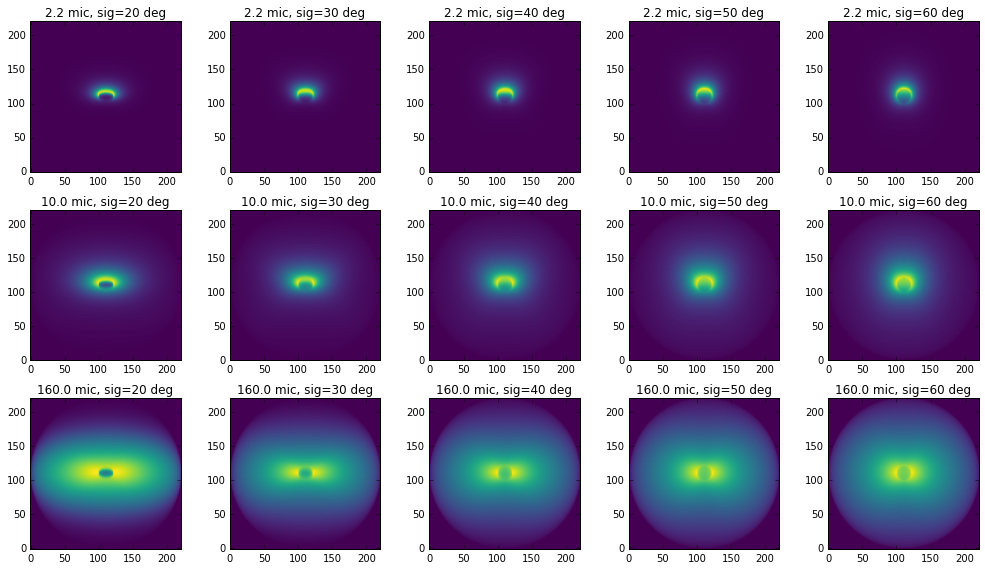

In [15]:
images = [image[js,...,jw] for jw in xrange(len(waves)) for js in xrange(len(sig))]  # extract the 2D image slices
images = [hypercat.mirror_halfimage(img) for img in images]  # make full (square) versions of them
multiplot(images,figsize=(14,8),geometry=(3,5),colorbars=False,titles=["%.1f mic, sig=%d deg" % e for e in itertools.product(waves,sig)])

## The `Image` object ##
You can use the images extracted via `get_image()` directly, they are simple Numpy arrays. However, you probably will prefer to get to know the `Image` object, which takes a raw image (currently 2D), and provides many useful methods to operate on it in a physical/astronomical fashion.

The reason while `Image` only deals with 2D images for now is that the angular resolution of a telescope (and of an interferometer) depends on the observed wavelenth, i.e. it is impossible to represent a multi-wavelength image as a 3D cube with the array gridding. In the future we may implement classes to deal with this transparently.

###Instantiation, pixelscale, brightness###
Begin as before with extracting a monochromatic 2D image from the cube:

In [16]:
theta = (30,60,3,0,20,10.0)
image = M.get_image(theta)

Instantiate an `Image` object, giving it physical meaning

In [17]:
I = hypercat.Image(image,pixelscale='1 arcsec',peak_pixel_brightness='1 mJy/pix')
print I.pixelscale

1.0 arcsec


You've initialized the image by feeding the raw data array and by setting the angular size of a pixel (`pixelsize`) and scaling the raw data such that the max pixel has value `peak_pixel_brightness`.

You can also set `pixelscale` using linear units (together with a `distance` to the source):

In [18]:
I = hypercat.Image(image,pixelscale='1 AU',distance='1 pc',peak_pixel_brightness='1 mJy/pix')
print I.pixelscale

1.0 arcsec


Have a look at the properties and methods of your object `I`, by typing `I.[+TAB]` in Ipython

```
(ipython)I.[+TAB]
I.CUNITS          I.UNITS_BRIGHTNESS   I.data_raw        I.getTotalFluxDensity
I.pixelarea       I.rotate             I.setPixelscale   I.FOV
I.UNITS_LINEAR    I.embedInFOV         I.npix            I.pixelscale
I.setBrightness   I.UNITS_ANGULAR      I.data            I.getBrightnessInUnits
I.pix             I.resample           I.setFOV
```

`I.data_raw` is always the original `image` array you fed to `Image` when creating it, it will never be altered. `I.data` however is more physical:

In [19]:
print I.data.shape, I.data.max() # only printing the max value here to save output

(221, 221) 1.0 mJy / pix


It is the brightness-per-pixel, and is an array of type 'Quantity', i.e. it has `value` and `unit`.

If you decide to adjust `pixelscale` or the peak-pixel-brightness, you can always do so using the respective functions directly:

In [20]:
# setting pixelscale directly; this does not update brightness!
print "setting pixelscale"
print "before:", I.pixelscale, I.data.max()
I.setPixelscale('30 mas')
print "after:", I.pixelscale, I.data.max()

# scaling brightness directly; this does not updated pixelscale!
print "\nsetting peak pixel brightness"
print "before:", I.pixelscale, I.data.max()
I.setBrightness('1.6 mJy/pix')
print "after:", I.pixelscale, I.data.max()

setting pixelscale
before: 1.0 arcsec 1.0 mJy / pix
after: 30.0 mas 1.0 mJy / pix

setting peak pixel brightness
before: 30.0 mas 1.0 mJy / pix
after: 30.0 mas 1.60000002384 mJy / pix


Beware that `setPixelscale()` and `setBrightness()` only set the values, but they are not aware of each other. i.e. setting one does not update the other!

We know both the brightness-per-pixel and the pixelscale. We thus can easily convert to brightness-per-angular-units:

In [21]:
print I.getBrightnessInUnits('uJy / mas^2').max() # microJansky / milliarcsec^2
print I.getBrightnessInUnits('Jy / arcsec^2').max()
print I.getBrightnessInUnits('GJy / sr').max() # GigaJansky per steradian
# or any other combination of "brightness-per-solid-angle" you can think of ("per-beam" still to be implemented though)

1.77777779102 uJy / mas2
1.77777779102 Jy / arcsec2
75.6358642578 GJy / sr


You can plot `I` just as easily as the raw images:

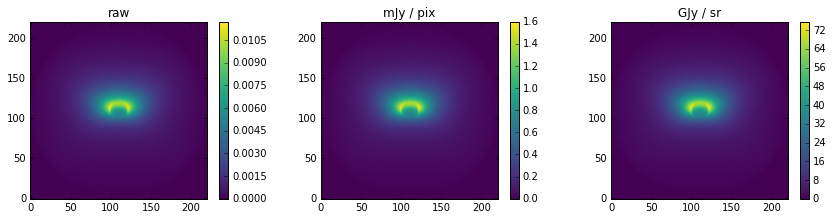

In [22]:
Iphysical = I.getBrightnessInUnits('GJy/sr')
images = (I.data_raw, I.data.value, Iphysical.value)
multiplot(images,figsize=(12,3),geometry=(1,3),titles=('raw',I.data.unit.to_string(),Iphysical.unit.to_string()))

###Total flux density###
You can compute the total flux density within the FOV:

In [23]:
total = I.getTotalFluxDensity()
print total

5.02888164483 Jy


This is always given in Jy, but you can convert easily, e.g.:

In [24]:
print total.to('mJy')
print total.to('MJy')
print total.to('ug/Gs^2') # micrograms/Gigaseconds^2 ;-)

5028.88164483 mJy
5.02888164483e-06 MJy
50.2888164483 ug / Gs2


###Modifying the FOV, embedding the image in a FOV, cropping###
You can directly set the physical image field-of-view in angular units, and the pixelscale will be updated automatically:

In [25]:
print "setting FOV, recomputes pixelscale"
print "before:", I.pixelscale, I.FOV
I.setFOV('10 arcsec')
print "after:", I.pixelscale, I.FOV

setting FOV, recomputes pixelscale
before: 30.0 mas 6630.0 mas
after: 0.0452488687783 arcsec 10.0 arcsec


It might be useful to either embed the model image within a larger FOV, or reversly, to crop from the image some smaller central FOV:

In [26]:
I = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix')

# making two other images to demonstrate embedding and cropping
Iembed = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix') # same initial state
Icrop = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix') # same initial state

items = ('shape','pixelscale','FOV','totalFluxDensity')
def diagnostics2str(img):
    values = (img.data.shape, img.pixelscale, img.FOV, img.getTotalFluxDensity())
    return ", ".join(["%s=%s" % e for e in zip(items,values)])

print "orig:", diagnostics2str(I)

Iembed.embedInFOV('10 arcsec')
print "embed:", diagnostics2str(Iembed) # total flux density preserved b/c embedding is just padding with zeros

Icrop.embedInFOV('3 arcsec')
print "crop:", diagnostics2str(Icrop) # flux lost b/c of cropping

orig: shape=(221, 221), pixelscale=30.0 mas, FOV=6630.0 mas, totalFluxDensity=3.14305108041 Jy
embed: shape=(333, 333), pixelscale=30.0 mas, FOV=9990.0 mas, totalFluxDensity=3.14305108041 Jy
crop: shape=(99, 99), pixelscale=30.0 mas, FOV=2970.0 mas, totalFluxDensity=2.1673661191 Jy


Observe how embedding in a larger FOV preserves total flux density, but cropping doesn't.

Note also that b/c of the requirement that `I.npix` be an odd integer, the actual FOV may have been adjusted to the closest odd integer.

Let's plot:

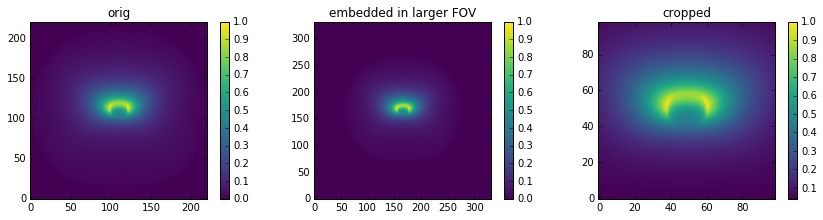

In [27]:
images = (I.data.value,Iembed.data.value,Icrop.data.value)
multiplot(images,figsize=(12,3),geometry=(1,3),titles=('orig','embedded in larger FOV','cropped'))

**Be careful!** If you crop the current FOV (i.e. your desired FOV is smaller than the current FOV), then `I.data` in this object is cropped permanently:

original FOV: 6630.0 mas
cropped FOV: 2970.0 mas
un-cropped FOV: 6630.0 mas


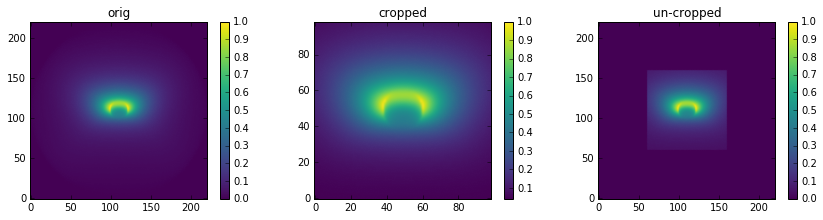

In [28]:
images = []
I = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix')
fov_orig = I.FOV  # storing original FOV
images.append(I.data.value)
print "original FOV:", I.FOV

I.embedInFOV('3 arcsec')  # cropping
images.append(I.data.value)
print "cropped FOV:", I.FOV

I.embedInFOV(fov_orig)  # 'un-doing' the cropping
images.append(I.data.value)
print "un-cropped FOV:", I.FOV

multiplot(images,figsize=(12,3),geometry=(1,3),titles=('orig','cropped','un-cropped'))

###Image rotation##
Another very useful method allows to rotate an image by an arbitrary angle. This is very important when extracting correlated fluxes (inteferometry), due to the position angle (PA) of the interferometer baseline. Let's rotate the above image from it's current orientation 90 degrees East-wards, in steps of 10 degrees:

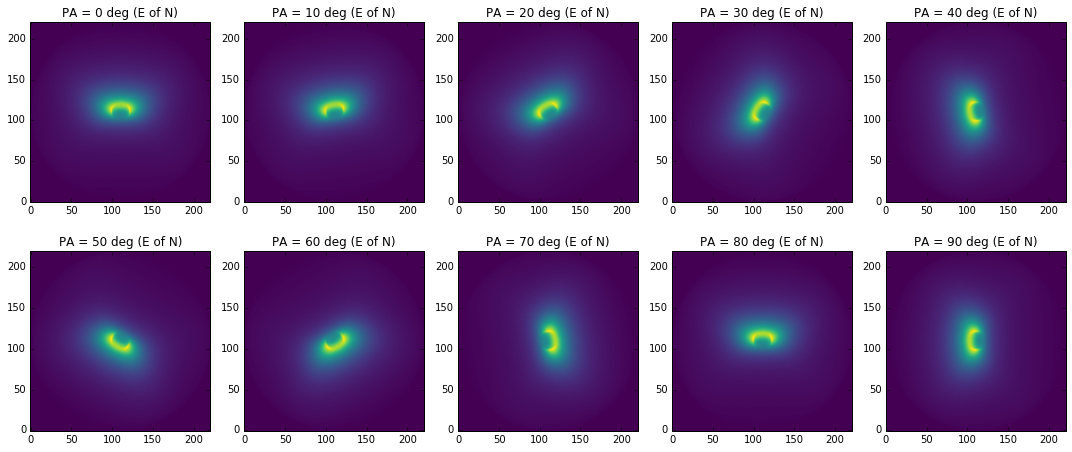

In [29]:
I = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix')
angles = N.linspace(0,90,10)
images = [I.rotate(deg,returnimage=True).value for deg in angles]
#images = [hypercat.rotate_image(image,deg) for deg in angles]
multiplot(images,figsize=(15,6.5),geometry=(2,5),colorbars=False,\
          titles=['PA = %d deg (E of N)' % deg for deg in angles])

You can of course freely combine the operations on a given image, e.g.:

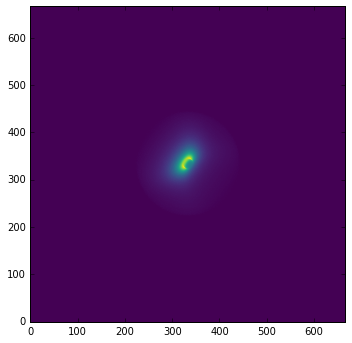

In [30]:
I = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix')
I.embedInFOV('20 arcsec')
I.rotate(55,direction='NE')
multiplot((I.data.value,),figsize=(5,5),geometry=(1,1),colorbars=False)

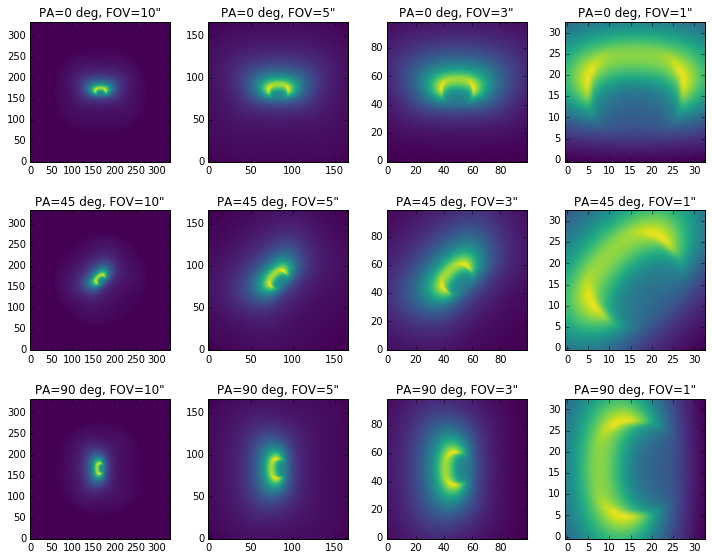

In [31]:
fovs = (10,5,3,1) # arcsec
angles = (0,45,90) # degrees

images = [] 
for angle in angles:
    I = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix')
    I.rotate(angle)
    for fov in fovs:
        I.embedInFOV(fov*u.arcsec)
        images.append(I.data.value)
        
multiplot(images,figsize=(10,8),geometry=(3,4),colorbars=False,\
          titles=["PA=%d deg, FOV=%d\"" % e for e in itertools.product(angles,fovs)])

###Resampling the image###

**hypercat** also provides a method to resample the image, i.e. to increase (upsample) or decrease (downsample) the number of pixels in the image array (via 3rd order spline interpolation). This function transparently adjusts `I.pixelsize` and the scale of the brightness array `I.data`. `I.FOV` is not altered by resampling.

resampled 1.0x: npix = 221, pixelscale = 30.0 mas, FOV = 6630.0 mas, totalFluxDensity = 3.14305108041 Jy
resampled 2.0x: npix = 443, pixelscale = 14.9661399549 mas, FOV = 6630.0 mas, totalFluxDensity = 3.15738592464 Jy
resampled 0.1x: npix = 23, pixelscale = 288.260869565 mas, FOV = 6630.0 mas, totalFluxDensity = 2.89628806817 Jy


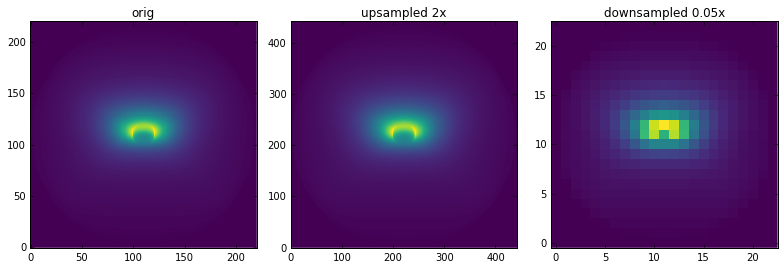

In [32]:
images = []

I = hypercat.Image(image,pixelscale='30 mas',peak_pixel_brightness='1 mJy/pix')

for resamp in (1.,2.,0.05):
    I.resample(resamp)
    images.append(I.data.value)
    print "resampled %.1fx: npix = %s, pixelscale = %s, FOV = %s, totalFluxDensity = %s" %\
        (resamp, I.npix, I.pixelscale, I.FOV, I.getTotalFluxDensity())

multiplot(images,figsize=(11,4),geometry=(1,3),colorbars=False,\
          titles=('orig','upsampled 2x','downsampled 0.05x'),interpolation='none')

_Resampling does not alter the total flux density, at least in principle._ When `I.npix` is small, the interpolation accuracy suffers, and effectively the total flux density is slightly altered.

###More to come!###
(e.g. modules/classes for PSFs, interferomery, morphology, ...)